# HAND SEGMENTATION via U-net architecture with pretrained VGG19 model as encoder backbone

Using UltimateDataset

Trying to increase performances with respect to model achieving 72% Dice score with randomly initialized weights.

Images already resized (to 224x224) and preprocessed are loaded as zip files on Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [3]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 699673284582797184
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 16139419648
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 14052026774678546375
 physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
 xla_global_id: 416903419]

In [4]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


Unzip files into 'color' and 'segmented' folders. (run unzipping code only first time)

In [5]:
#!unzip -q /content/drive/MyDrive/UltimateDataset/color.zip -d /content/drive/MyDrive/UltimateDataset/color

In [6]:
#!unzip -q /content/drive/MyDrive/UltimateDataset/segmented.zip -d /content/drive/MyDrive/UltimateDataset/segmented

Import all needed modules

In [7]:
import tensorflow as tf
from tensorflow import keras
from keras import layers

import matplotlib.pyplot as plt
import numpy as np

import os
import glob
import PIL
from PIL import ImageOps
from PIL import Image

import time
from IPython.display import Image, display

from keras.preprocessing.image import load_img, img_to_array, array_to_img
from tensorflow.keras.applications.vgg19 import preprocess_input as preprocess_input_VGG19

Since the dataset we will use is pretty heavy (ca. 7828 images) we can not load all in its entirety (otherwise saturating RAM), therefore we extend Sequence class of keras to load it when required by batches of size batch_size

Here we prepare the filename list, shuffling it to have more variety between images (otherwise loaded sequentially by similar "hand letter" or similar by dataset content).

Images are already resized in processing to size 224x224. As the model is easier to define if we use an input and output size of 256x256 we will need to resize the images when loading them.

In [8]:
# paths in drive to input and output images
color_folder = '/content/drive/MyDrive/UltimateDataset/color/color'
segmented_folder = '/content/drive/MyDrive/UltimateDataset/segmented/segmented'

print(len(os.listdir(color_folder)))
print(len(os.listdir(segmented_folder)))

7828
7828


#### Check that NUMBER OF IMAGES IS THE SAME and below that PATH PAIRS ARE CONSISTENT

In [9]:
img_size = (256, 256) 
num_classes = 1 # 2 classes (hand, non hand) but we just need 1 depth layer to represent a probability between 0 and 1
batch_size = 16 # would be nicer to work with 32 size batch but Google colab runs OOM

color_images_path = sorted([os.path.join(color_folder, fname) for fname in os.listdir(color_folder) if fname.endswith(".png") or fname.endswith(".jpg")])
segmented_images_path = sorted([os.path.join(segmented_folder, fname) for fname in os.listdir(segmented_folder) if fname.endswith(".png") or fname.endswith(".jpg")])

# The sorted in above code was for ensuring that the color-segmented pairs were loaded in same order
# I want to shuffle the dataset to destroy correlation between images as dataset is made up of letters of mute sign
# Applying same shuffling to both path lists
from sklearn.utils import shuffle
color_images_path, segmented_images_path = shuffle(color_images_path, segmented_images_path, random_state=23)

print("Number of colored instances: ", len(color_images_path))
print("Number of segmented instances: ", len(segmented_images_path))

# checking some random pairs 1 to 1 correspondence
for c, s in zip(color_images_path[:10], segmented_images_path[:10]):
    print(c, "|", s)

Number of colored instances:  7828
Number of segmented instances:  7828
/content/drive/MyDrive/UltimateDataset/color/color/augmented381hof.jpg | /content/drive/MyDrive/UltimateDataset/segmented/segmented/augmented381hof.jpg
/content/drive/MyDrive/UltimateDataset/color/color/2859.png | /content/drive/MyDrive/UltimateDataset/segmented/segmented/2859.png
/content/drive/MyDrive/UltimateDataset/color/color/397eyth4.png | /content/drive/MyDrive/UltimateDataset/segmented/segmented/397eyth4.png
/content/drive/MyDrive/UltimateDataset/color/color/74lc3.png | /content/drive/MyDrive/UltimateDataset/segmented/segmented/74lc3.png
/content/drive/MyDrive/UltimateDataset/color/color/59lc2.png | /content/drive/MyDrive/UltimateDataset/segmented/segmented/59lc2.png
/content/drive/MyDrive/UltimateDataset/color/color/1311.png | /content/drive/MyDrive/UltimateDataset/segmented/segmented/1311.png
/content/drive/MyDrive/UltimateDataset/color/color/2088.png | /content/drive/MyDrive/UltimateDataset/segmented/seg

Display an input colored image and its corresponding ground truth mask

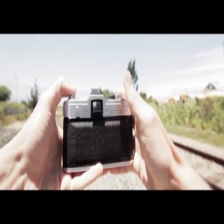

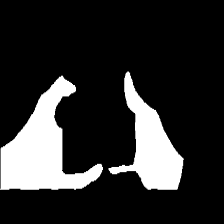

In [10]:
display(Image(filename=color_images_path[4600]))

display(Image(filename=segmented_images_path[4600]))

We cannot afford to load all images in once, therefore we extend Sequence class of keras to load instances as batches of batch_size

### NOTE: 
- "Normalization" of input is done through "preprocess_input" provided by VGG19 model, which converts image from RGB to BGR, then each color channel is zero-centered with respect to the ImageNet dataset, WITHOUT SCALING.

- We scale output to [0,1] values and add 1 dimension to match model output layer (img_size, img_size, 1)

In order to regularize the model and not overfit on test data we perform 
## Data augmentation 
This is done on the fly during training to not overload dataset size.


#### NB: cv2 loads images in BGR, then Albumentations requires images in RGB (we need to convert manually), but then preprocess_input of VGG19 converts images back to BGR (done internally). 

In [11]:
import albumentations as A
import cv2

# helpful to visualize image
def visualize(image, color=True):
    plt.figure(figsize=(5, 5))
    plt.axis('off')
    if color == True:
      plt.imshow(image)
    else:
      plt.imshow(image, cmap='gray')

Defining an augmentation composition and testing on a single image before using it in HandDataset Sequence loader.

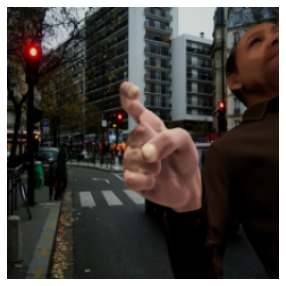

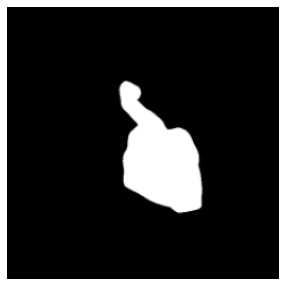

In [12]:
i = 23 # which img to test?
pathColored = color_images_path[i]
pathSegmented = segmented_images_path[i]

imgColor = cv2.imread(pathColored)
# CONVERSION NEEDED as albumentation works in RGB
imgColor = cv2.cvtColor(imgColor, cv2.COLOR_BGR2RGB)
# RESIZING TO 256 x 256 needed
resized_imgColor = cv2.resize(imgColor, img_size) 
visualize(resized_imgColor)

imgSegmented = cv2.imread(pathSegmented, cv2.IMREAD_GRAYSCALE)
resized_imgSegmented = cv2.resize(imgSegmented, img_size) 
visualize(resized_imgSegmented, False)

def augmentation(p=0.5):
    return A.Compose([
        A.OneOf([
            A.RandomRotate90(p=0.2),
            A.Flip(p=0.2),
            A.Transpose(p=0.2),
            A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=0.2),
            A.OpticalDistortion(p=0.2),
            A.RandomSizedCrop(min_max_height=(150, 150), height=256, width=256, p=0.2)
        ], p=p),            
        A.OneOf([
            A.GaussNoise(p=0.2),
            A.CLAHE(clip_limit=2),
            A.IAASharpen(),
            A.IAAEmboss(),
            A.RandomBrightnessContrast(p=0.3),
            A.RGBShift(p=0.2)
        ], p=p)
    ])

augmentedImg = augmentation(p=0.5)

[[[ -84.939     -95.779    -106.68    ]
  [ -82.939     -94.779    -105.68    ]
  [ -81.939     -93.779    -104.68    ]
  ...
  [-101.939    -113.779    -113.68    ]
  [-101.939    -113.779    -114.68    ]
  [-102.939    -113.779    -116.68    ]]

 [[ -85.939     -96.779    -107.68    ]
  [ -84.939     -95.779    -106.68    ]
  [ -82.939     -94.779    -104.68    ]
  ...
  [-101.939    -113.779    -114.68    ]
  [-102.939    -113.779    -115.68    ]
  [-103.939    -115.779    -118.68    ]]

 [[ -89.939    -100.779    -110.68    ]
  [ -86.939     -97.779    -107.68    ]
  [ -83.939     -95.779    -105.68    ]
  ...
  [-102.939    -114.779    -116.68    ]
  [-102.939    -115.779    -118.68    ]
  [-103.939    -116.779    -120.68    ]]

 ...

 [[ -53.939003  -64.779     -74.68    ]
  [ -47.939003  -58.779     -69.68    ]
  [ -46.939003  -57.779     -69.68    ]
  ...
  [ -59.939003  -75.779     -88.68    ]
  [ -59.939003  -75.779     -88.68    ]
  [ -70.939     -86.779     -98.68    ]]

 [

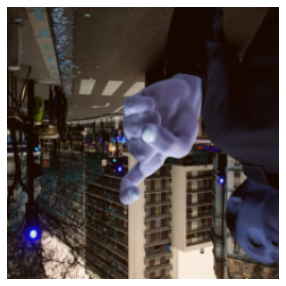

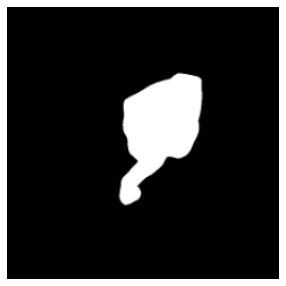

In [13]:
data = {"image": resized_imgColor, "mask": resized_imgSegmented}
augmented = augmentedImg(**data)

color_augmented, seg_augmented = augmented["image"], augmented["mask"]

# converting img to array, preprocessing it and converting back to array
color = array_to_img(preprocess_input_VGG19(img_to_array(color_augmented)))

visualize(color)
visualize(seg_augmented, False)
print(preprocess_input_VGG19(img_to_array(color_augmented))) # to see what looks like preprocessed image as array
print(seg_augmented.shape)

#### Let's extend keras Sequence class to load images by batches of batch_size and perform DataAugmentation on the fly using the above defined function

We have to be careful that:
- we need to apply same augmentation on color and segmented image
- load images using cv
- converting from BGR to RGB
- converting to array when creating batch tensor of instances
- normalize segmented images s.t. output is in 0,1 values spannable by sigmoid 
- preprocess input images through preprocess_input of VGG19

In [14]:
class HandsDataset(keras.utils.Sequence):

  def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
    self.batch_size = batch_size
    self.img_size = img_size
    self.input_img_paths = color_images_path
    self.target_img_paths = segmented_images_path
    self.augmentedImg = augmentation(p=0.5)

  # total number of batches 
  def __len__(self):
    return len(self.target_img_paths) // self.batch_size 

  def __getitem__(self, idx):
    """Returns tuple (input, target) correspond to batch #idx."""
    i = idx * self.batch_size #compute starting absolute index given current batch number and its dimension
    # paths of the images we have to load
    batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
    batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
    
    x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32") # tensor in which colored images will be stored
    y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="float32") # tensor in which segmented images will be stored
    
    for j in range(0, len(batch_input_img_paths)):
      # load color image using cv2 and convert it from BGR to RGB (required by Albumentation)
      imgColor = cv2.imread(batch_input_img_paths[j])
      imgColor = cv2.cvtColor(imgColor, cv2.COLOR_BGR2RGB)
      resized_imgColor = cv2.resize(imgColor, img_size) 
      # load segmented corresponding mask
      imgSegmented = cv2.imread(batch_target_img_paths[j], cv2.IMREAD_GRAYSCALE)
      resized_imgSegmented = cv2.resize(imgSegmented, img_size)

      # Apply augmentation on both
      data = {"image": resized_imgColor, "mask": resized_imgSegmented}
      augmented = self.augmentedImg(**data)
      color_augmented, seg_augmented = augmented["image"], augmented["mask"]

      x[j] = preprocess_input_VGG19(img_to_array(color_augmented)) # preprocess input 
      y[j] = (img_to_array(seg_augmented)).astype('float32')/255 # scale output in range [0,1]

    return x, y

## Defining U-net model with VGG19 pretrained model as encoder backbone

In [15]:
from tensorflow.keras.applications import VGG19
# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

# To ensure channel is last dimension
from keras import backend as K
K.set_image_data_format('channels_last')

Defining double convolution block used as part of each decoder block.

In [16]:
def double_conv_block(inputs, num_filters):
  x = layers.Conv2D(num_filters, 3, padding="same")(inputs)
  x = layers.BatchNormalization()(x)
  x = layers.Activation("relu")(x)

  x = layers.Conv2D(num_filters, 3, padding="same")(x)
  x = layers.BatchNormalization()(x)
  x = layers.Activation("relu")(x)

  return x

In [17]:
def decoder_block(inputs, skip_features, num_filters):
  x = layers.Conv2DTranspose(num_filters, (2,2), strides=2, padding="same")(inputs)
  x = layers.Concatenate()([x, skip_features])
  x = layers.Dropout(0.3)(x)
  x = double_conv_block(x, num_filters)
  return x

In [18]:
def get_VGG19_Unet_Model(img_size, num_classes):
  # input
  inputs = keras.Input(shape=img_size + (3,))
  # Pretrained VGG19 as encoder 
  vgg19 = VGG19(include_top=False, weights="imagenet", input_tensor=inputs)

  #vgg19.summary()

  # getting references to layers for skip connections
  s1 = vgg19.get_layer("block1_conv2").output #256
  s2 = vgg19.get_layer("block2_conv2").output #128
  s3 = vgg19.get_layer("block3_conv4").output #64
  s4 = vgg19.get_layer("block4_conv4").output #32

  # bridge
  bridge = vgg19.get_layer("block5_conv4").output #16

  # Decoder construction
  d1 = decoder_block(bridge, s4, 512) #32
  d2 = decoder_block(d1, s3, 256) #64
  d3 = decoder_block(d2, s2, 128) #128
  d4 = decoder_block(d3, s1, 64) #256

  # Output layer
  outputs = layers.Conv2D(num_classes, 1, padding="same", activation="sigmoid")(d4)

  model = keras.Model(inputs, outputs, name="VGG19_Unet")

  return model

In [19]:
model = get_VGG19_Unet_Model(img_size, num_classes)
model.summary()

Model: "VGG19_Unet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 256, 256, 64  36928       ['block1_conv1[0][0]']           
                                )                                                        

### Split in train, validation and test

In [20]:
tp = 0.85 # train percentage
nInstances = len(color_images_path)

color_images_path_train, color_images_path_validTest = color_images_path[:int(tp*nInstances)], color_images_path[int(tp*nInstances):]
segmented_images_path_train, segmented_images_path_validTest = segmented_images_path[:int(tp*nInstances)], segmented_images_path[int(tp*nInstances):]

nInstancesVT = len(color_images_path_validTest)
color_images_path_valid, color_images_path_test = color_images_path_validTest[:int(0.5*nInstancesVT)], color_images_path_validTest[int(0.5*nInstancesVT):]
segmented_images_path_valid, segmented_images_path_test = segmented_images_path_validTest[:int(0.5*nInstancesVT)], segmented_images_path_validTest[int(0.5*nInstancesVT):]


# Instantiate data Sequences for each split
train_gen = HandsDataset(batch_size, img_size, color_images_path_train, segmented_images_path_train)
val_gen = HandsDataset(batch_size, img_size, color_images_path_valid, segmented_images_path_valid)

In [21]:
print(len(color_images_path_train))
print(len(segmented_images_path_train))
print(len(color_images_path_valid))
print(len(color_images_path_test))

6653
6653
587
588


### Training the model

Using DICE as metric to keep track of both hand and non hand classified pixels simultaneously

In [22]:
from keras import backend as K

# Let y_true be the tensor of segmented masks (n,256,256,1) (normalized) and y_pred the tensor of our predictions (n,256,256,1)
# Since we work with tensor we cannot use numpy but use backend
def dice_coef(y_true, y_pred, smooth=1):
  intersection = K.sum(y_true * y_pred, axis=[1,2,3]) # compute sum along width, height and channel axis
  union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
  dice = K.mean((2. * intersection + smooth)/(union + smooth), axis=0) # Now along all instances
  return dice

In [23]:
# Configure the model for training
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=[dice_coef])

# Early stopping
# Let's define a log dir in order to save the checkpoint file
logdir = os.path.join(os.curdir, "my_logs", "run_{}".format(time.time()))

modelPath = os.path.join(os.curdir, "handSegmentationUnet.h5")

callbacks = [
    keras.callbacks.TensorBoard(logdir),
    keras.callbacks.EarlyStopping(patience=10, verbose=1, restore_best_weights=True),

    #Saving the checkpoints file allows to load the "best" model when the Early 
    #stopping detect that the generalization error degrade (after 'patience' epochs)
    keras.callbacks.ModelCheckpoint(modelPath, save_best_only=True, verbose=1),
]

# Train the model, doing validation at the end of each epoch.
epochs = 100
history = model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)

Epoch 1/100
489/489 [==============================] - ETA: 0s - loss: 0.4306 - dice_coef: 0.3006
Epoch 1: val_loss improved from inf to 0.26442, saving model to ./handSegmentationUnet.h5
489/489 [==============================] - 327s 651ms/step - loss: 0.4306 - dice_coef: 0.3006 - val_loss: 0.2644 - val_dice_coef: 0.3908
Epoch 2/100
489/489 [==============================] - ETA: 0s - loss: 0.1695 - dice_coef: 0.4701
Epoch 2: val_loss improved from 0.26442 to 0.14526, saving model to ./handSegmentationUnet.h5
489/489 [==============================] - 314s 642ms/step - loss: 0.1695 - dice_coef: 0.4701 - val_loss: 0.1453 - val_dice_coef: 0.5090
Epoch 3/100
489/489 [==============================] - ETA: 0s - loss: 0.1320 - dice_coef: 0.5491
Epoch 3: val_loss improved from 0.14526 to 0.12856, saving model to ./handSegmentationUnet.h5
489/489 [==============================] - 313s 640ms/step - loss: 0.1320 - dice_coef: 0.5491 - val_loss: 0.1286 - val_dice_coef: 0.6011
Epoch 4/100
489/4

In [24]:
def plot_loss(history):
    plt.figure(figsize=(10,6))
    plt.plot(history.epoch,history.history['loss'])
    plt.plot(history.epoch,history.history['val_loss'])
    plt.grid()
    plt.title('loss')

def plot_accuracy(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch,history.history['dice_coef'],label='dice_coef')
  plt.plot(history.epoch,history.history['val_dice_coef'],label='val_dice_coef')
  plt.title('dice_coef')
  plt.legend()

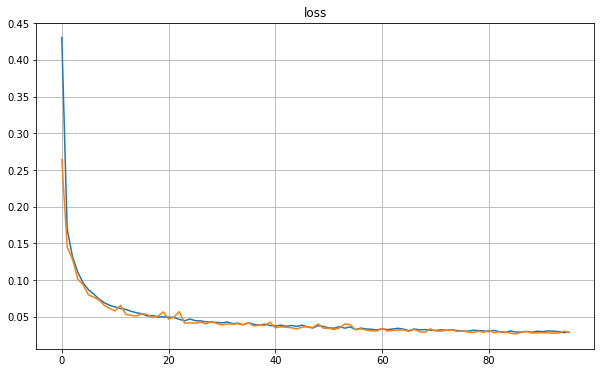

In [25]:
plot_loss(history)

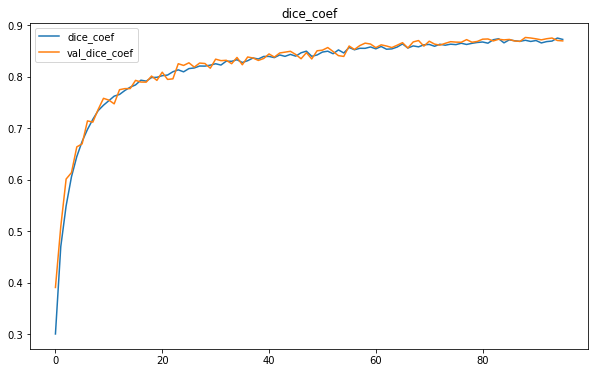

In [26]:
plot_accuracy(history)

In [27]:
test_gen = HandsDataset(batch_size, img_size, color_images_path_test, segmented_images_path_test)
scores = model.evaluate(test_gen, verbose=2)
print("Test loss score: %.5f" % (scores[0]))
print("Test Dice score: %.5f" % (scores[1]))

489/489 - 94s - loss: 0.0272 - dice_coef: 0.8740 - 94s/epoch - 192ms/step
Test loss score: 0.02723
Test Dice score: 0.87400


In [28]:
model = tf.keras.models.load_model('/content/handSegmentationUnet.h5', compile='true', custom_objects={"dice_coef": dice_coef})

In [29]:
model.save('/content/drive/MyDrive/handSegmentationUnetVGG19Wednesday.h5')